# A generic notebook to perform analysis of SWAXS data at FORMAX

# Part I - file structure.

The data we have at FORMAX is gathered by two sensors. 

- lambda, which measures the Wide Angle X-ray Scattering (WAXS)
- eiger, which measures the Small Angle X-ray Scattering (SAXS)

The sensors measure the number of photons (TO BE VERIFIED) hitting each pixel for a given exposure time. This is the raw data.

For each scan, there are three files that are stored as [h5 files](https://www.hdfgroup.org/solutions/hdf5/) in the /raw/ folder, which houses this data:

- scan-xxxx.h5: The master file for the scan, containing useful metadata for the scan.
- scan-xxxx_lambda.h5: The data from the lambda sensor.
- scan-xxxx_eiger.h5: The data from the eiger sensor.


Let us load the data first.

In [3]:

import h5py #Open and manage h5 files with python
import hdf5plugin #Loading the raw data will not work without it
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

from svg_parse import svg_parse

In [ ]:
#Some useful variables:
proposal = 20240661 
visit = 2024102408
scan = 44 #Set it yourself!

## Raw sensor data plotting

Let us load the raw sensor data and plot it.

In [5]:
def plot_raw_lambda_data(filepath,which_image, ax = None):
    """Reads the raw data from the lambda hdf5 file and reconstructs the full image"""
    # filepath = os.path.join(DATA_FOLDER, 'scan-%04d_%s.h5' % (nbr, 'lambda'))
    ax = plt.gca() if ax is None else ax
    with h5py.File(filepath, 'r') as fh:
        full_shape = fh['/entry/instrument/lambda/full_shape'][()]
        rotation = fh['/entry/instrument/lambda/rotation'][()]
        x = fh['/entry/instrument/lambda/x'][()]
        y = fh['/entry/instrument/lambda/y'][()]
        data = fh['/entry/instrument/lambda/data'][which_image,:,:,:]
    fulldata = np.empty(full_shape)
    fulldata[:] = np.nan
    for i in range(4):
        rotdata = np.rot90(data[i,:,:], -rotation[i]/90) # rotate each detector
        fulldata[y[i]:y[i]+rotdata.shape[0],x[i]:x[i]+rotdata.shape[1]] = rotdata
    ax.imshow(fulldata, norm = "log")



def plot_raw_eiger_data(filepath,which_image, ax = None):
    ax = plt.gca() if ax is None else ax
    with h5py.File(filepath, 'r') as fh:
        data = np.array(fh['/entry/instrument/eiger/data'][which_image,:,:]).astype(np.float32)
       
    # set values above 1e9 to NaN
    data[data>1.e9] = np.nan
    ax.imshow(data, norm = mcolors.SymLogNorm(1e-3, vmin=1e-1, vmax=1e2), origin='lower')


Text(0.5, 1.0, 'SAXS')

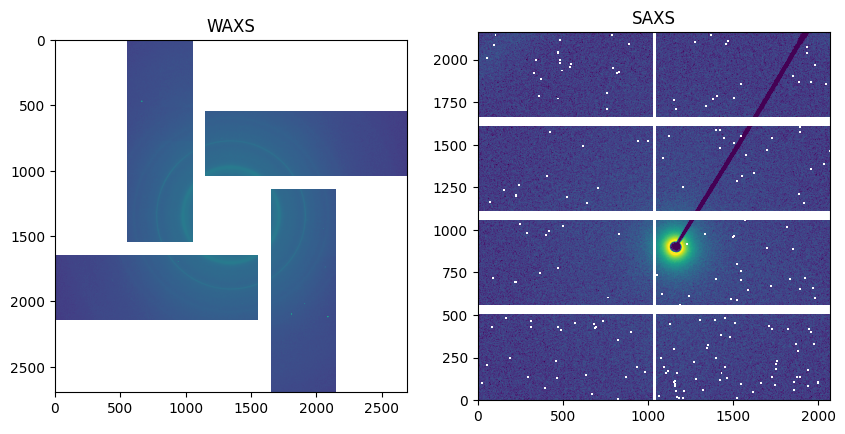

In [ ]:
det = "eiger"
fpath_eiger = "C:\\Users\\SEFOURNIERME\\OneDrive - Tetra Pak\\Documents\\MAX IV files\\raw\\scan-%04d_%s.h5" %(scan, det)

det = "lambda"
fpath_lambda = "C:\\Users\\SEFOURNIERME\\OneDrive - Tetra Pak\\Documents\\MAX IV files\\raw\\scan-%04d_%s.h5" %(scan, det)

fig, [ax1,ax2] = plt.subplots(1,2, figsize = (10,10))

image_number = 2000 #Each scan consists of a lot of measurements, here as part of a "snake scan"

plot_raw_lambda_data(fpath_lambda,1000,ax1)
ax1.set_title("WAXS")


det = "eiger"
fpath_eiger = "C:\\Users\\SEFOURNIERME\\OneDrive - Tetra Pak\\Documents\\MAX IV files\\raw\\scan-%04d_%s.h5" %(scan, det)

plot_raw_eiger_data(fpath_eiger,2000,ax2)
ax2.set_title("SAXS")
    

## Azimuthal integrated data

Stored this way, the data is not really useful. We have to account for the relative position of each detector plate, and we have our data in cartesian coordinate. For most applications, we are interested in measuring our intensities $I$ as a function of the modulus of the scattering vector $|\mathbf{q}| = \frac{4 \pi \sin \theta}{\lambda}$, and the azimuthal angle $\xi$.

Moving from the cartesian coordinate of the sensor $I(x,y)$ to the radial coordinate system $I(q,\xi)$ is called azimuthal integration, and this is done automatically for each scan at MAX IV. The azimuthally integrated data is available in the /process/azint/ folder. For each scan, there are two files with the name scan-xxxx_detector_integrated.py where detector is either lambda or eiger. 


In [7]:
def load_data(proposal,visit,scan, det, cluster='maxiv'):
    """
    Load the azimuthal integrated data and returns a dictionary with the keys that are explained below
    
    Arguments:
     - proposal: The proposal number
     - visit: The visit number
     - scan: The scan number
     - det: "eiger" (For SAXS data) or "lambda" (for WAXS data)
    
    keys in file that will be loaded
        **FROM AZINT FILE**
        'I' : cake plot from radial integration, ordering (image,azimuthal,q) 
        'azi', : azimuthal bins
        'mask_file', : file path for mask used for radial integration
        'norm', : weights/norm sum for computing averages for integrated data, (azimuthal and q)
        'polarization_factor', : polarisation factor used for integration
        'poni_file', : file path for pony file
        'q', : q Vektor for integration
        **FROM MASTER FILE**
        'i_t', : diode data, transmittance for 2D map
        'dt' : exposure time from eiger/lambda/diode
        'title' :  scan command from SPOCK
        'swaxs_x' : swaxs_x stage position (encoder reading)
        'swaxs_y' : swaxs_y stage position (theoretical reading)
        'swaxs_rot' : swaxs_y stage position (theoretical reading)
        'time' : time point for triggers for exposure
    """
    if cluster == 'maxiv':
        fname = '/data/visitors/formax/%s/%s/process/azint/scan-%04d_%s_integrated.h5' %(proposal, visit, scan, det)
    elif cluster == 'lunarc':
        fname = '/projects/maxiv/visitors/formax/%s/%s/process/azint/scan-%04d_%s_integrated.h5' %(proposal, visit, scan, det)
    elif cluster == "custom":
        fname = "C:\\Users\\SEFOURNIERME\\OneDrive - Tetra Pak\\Documents\\MAX IV files\\process\\azint\\scan-%04d_%s_integrated.h5" %(scan, det)
        print(fname)
        
    else:
        print("Clustername is not recognised")
        
    data = {}
    items = {
         'I': 'entry/data2d/cake',
         'q': 'entry/data1d/q',
         'azi' : 'entry/data2d/azi',
         'mask_file':'entry/azint/input/mask_file',
         'norm':'entry/data2d/norm',
         'polarization_factor':'entry/azint/input/polarization_factor',
         'poni':'entry/azint/input/poni',   
    }
    with h5py.File(fname, 'r') as fh:
        for key, name in items.items():
            if name in fh:
                data[key] = fh[name][()]  
            
    # master file
    if cluster == "home":
        master = fname.replace('process\\azint', 'raw')
    else:
        master = fname.replace('process/azint', 'raw')
    master = master.replace('_%s_integrated' %det, '')
    items = {
        'i_t': 'entry/instrument/albaem-e01_ch1/data',   
         'title': 'entry/title'                       
    }
    with h5py.File(master, 'r') as fh:
        for key, name in items.items():
            if name in fh:
                data[key] = fh[name][()]

    # fly or step scan
    fly_scan = False
    if fly_scan == True:
        data['shape'] = (int((str(data['title']).split(' '))[8])+1, int((str(data['title']).split(' '))[4]))
    else:
        data['shape'] = (int((str(data['title']).split(' '))[8])+1, int((str(data['title']).split(' '))[4])+1)
    return data
